In [1]:
import msprime
import stdpopsim
import pyslim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tskit
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

/home/mila/m/matthew.scicluna/ActiveProjects/ManyLatents/.venv/lib/python3.9/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/home/mila/m/matthew.scicluna/ActiveProjects/ManyLatents/.venv/lib/python3.9/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
import phate

In [42]:
# def make_demography_with_admixture(
#     num_pops,
#     split_time,
#     admixture_matrix,
#     ancestral_name="ANC",
#     root_size=1e4,
#     pop_size=1e4,
# ):
#     """
#     Create a demography with K populations split from one ancestor and with fixed admixture proportions.

#     Parameters:
#     - num_pops (int): Number of derived populations.
#     - split_time (float): Time at which the ancestral population splits into K populations.
#     - admixture_matrix (np.ndarray): K x K matrix of migration/admixture proportions.
#     - ancestral_name (str): Name of the root population.
#     - root_size (float): Size of ancestral population.
#     - pop_size (float): Size of each derived population.

#     Returns:
#     - msprime.Demography object
#     """
#     assert admixture_matrix.shape == (num_pops, num_pops), "Admixture matrix must be KxK"

#     demog = msprime.Demography()

#     # Add ancestral population
#     demog.add_population(name=ancestral_name, initial_size=root_size)

#     # Add K populations
#     pop_names = [f"POP_{i}" for i in range(num_pops)]
#     for name in pop_names:
#         demog.add_population(name=name, initial_size=pop_size)

#     # Split K populations from the ancestor
#     demog.add_population_split(time=split_time, derived=pop_names, ancestral=ancestral_name)

#     # Add constant migration/admixture rates using the matrix
#     for i in range(num_pops):
#         for j in range(num_pops):
#             if i != j and admixture_matrix[i, j] > 0:
#                 demog.set_migration_rate(source=pop_names[i],
#                                          dest=pop_names[j],
#                                          rate=admixture_matrix[i, j])

#     return demog

def make_demography_with_admixture(
    num_pops,
    split_time,
    admixture_matrix,
    admixture_start_time=10,
    admixture_end_time=0,
    ancestral_name="ANC",
    root_size=1e4,
    growth_rate=0.004,
    pop_size=1e4,
):
    """
    Create a demography with K populations split from one ancestor and with fixed admixture 
    proportions starting at admixture_start_time and stopping at admixture_end_time.

    Parameters:
    - num_pops (int): Number of derived populations.
    - split_time (float): Time at which the ancestral population splits into K populations.
    - admixture_matrix (np.ndarray): K x K matrix of migration/admixture proportions.
    - admixture_start_time (float): Time when admixture begins (in generations ago).
    - admixture_end_time (float): Time when admixture ends (0 = present).
    - ancestral_name (str): Name of the root population.
    - root_size (float): Size of ancestral population.
    - pop_size (float): Size of each derived population.

    Returns:
    - msprime.Demography object
    """
    assert admixture_matrix.shape == (num_pops, num_pops), "Admixture matrix must be KxK"

    demog = msprime.Demography()

    # Add ancestral population
    demog.add_population(name=ancestral_name, initial_size=root_size)

    # Add K derived populations
    pop_names = [f"POP_{i}" for i in range(num_pops)]
    for name in pop_names:
        demog.add_population(name=name, initial_size=pop_size, growth_rate=growth_rate)

    # Split K populations from ancestor
    demog.add_population_split(time=split_time, derived=pop_names, ancestral=ancestral_name)

    # Ensure zero migration to start with (optional, msprime defaults to 0)
    for i in range(num_pops):
        for j in range(num_pops):
            if i != j:
                demog.set_migration_rate(source=pop_names[i], dest=pop_names[j], rate=0.0)

    # Turn on migration at admixture_start_time
    for i in range(num_pops):
        for j in range(num_pops):
            if i != j and admixture_matrix[i, j] > 0:
                demog.add_migration_rate_change(
                    time=admixture_start_time,
                    source=pop_names[i],
                    dest=pop_names[j],
                    rate=admixture_matrix[i, j]
                )

    # Optional: turn off migration again at admixture_end_time
    if admixture_end_time > 0:
        for i in range(num_pops):
            for j in range(num_pops):
                if i != j and admixture_matrix[i, j] > 0:
                    demog.add_migration_rate_change(
                        time=admixture_end_time,
                        source=pop_names[i],
                        dest=pop_names[j],
                        rate=0.0
                    )
    
    demog.sort_events()

    return demog

def simulate_tree_sequence(
    samples_dict,
    demography,
    sequence_length=1e7,
    recomb_rate=1e-8,
    mut_rate=1.2e-8,
    seed_ancestry=42,
    seed_mutation=43,
):
    ts = msprime.sim_ancestry(
        samples=samples_dict,
        demography=demography,
        sequence_length=sequence_length,
        recombination_rate=recomb_rate,
        random_seed=seed_ancestry,
    )
    ts = msprime.sim_mutations(
        ts, rate=mut_rate, model=msprime.JC69(), random_seed=seed_mutation
    )
    return ts


def get_diploid_genotype_matrix(ts):
    haploid_G = ts.genotype_matrix().T
    haploid_G = np.minimum(haploid_G, 1)

    indiv_ids = ts.tables.nodes.individual[:]
    diploid_inds = np.unique(indiv_ids[indiv_ids >= 0])
    num_inds = len(diploid_inds)
    num_sites = haploid_G.shape[1]

    diploid_G = np.zeros((num_inds, num_sites), dtype=int)

    for k, ind_id in enumerate(diploid_inds):
        node_ids = ts.individual(ind_id).nodes
        diploid_G[k, :] = haploid_G[node_ids[0], :] + haploid_G[node_ids[1], :]

    return diploid_G


def extract_individual_metadata(ts):
    rows = []
    for ind in ts.individuals():
        if len(ind.nodes) != 2:
            continue
        node0 = ts.node(ind.nodes[0])
        rows.append({
            "individual_id": ind.id,
            "population": node0.population,
            "time": node0.time,
            "nodes": ind.nodes,
        })
    return pd.DataFrame(rows)


def trace_ancestry(ts, tracing_time=100, num_trees_to_sample=500):
    node_pop = ts.tables.nodes.population
    all_tree_indices = np.arange(ts.num_trees)
    sampled_indices = np.random.choice(all_tree_indices, size=num_trees_to_sample, replace=False)

    ancestry = np.zeros((ts.num_individuals, len(ts.populations())), dtype=float)

    for idx in tqdm(sampled_indices, desc="Assigning ancestry ratio using sampled trees"):
        tree = ts.at(idx)
        for i, ind in enumerate(ts.individuals()):
            for node in ind.nodes:
                anc_time = tree.get_time(node)
                current = node
                while anc_time < tracing_time and tree.parent(current) != tskit.NULL:
                    current = tree.parent(current)
                    anc_time = tree.time(current)
                pop = node_pop[current]
                ancestry[i, pop] += tree.span

    ancestry /= 2 * np.sum([ts.at(idx).span for idx in sampled_indices])

    # Label populations
    pop_names = [p.metadata.get("name", f"pop{p.id}") for p in ts.populations()]
    df = pd.DataFrame(ancestry, columns=pop_names)
    return df

def make_sample_dict(num_pops, samples_per_pop):
    """
    Create sample dictionary with names like 'POP_0', 'POP_1', ..., 'POP_{K-1}'.
    """
    return {f"POP_{i}": samples_per_pop for i in range(num_pops)}

def run_admixture_simulation(demography, num_pops, samples_per_pop=1000, tracing_time=100, num_trees_to_sample=500):
    samples = make_sample_dict(num_pops, samples_per_pop)
    ts = simulate_tree_sequence(samples_dict=samples, demography=demography)
    diploid_G = get_diploid_genotype_matrix(ts)
    metadata_df = extract_individual_metadata(ts)
    ancestry_df = trace_ancestry(ts, tracing_time=tracing_time, num_trees_to_sample=num_trees_to_sample)
    return ts, diploid_G, metadata_df, ancestry_df

In [50]:
K = 3

# Define asymmetric admixture rates (no self-admixture)
admix = np.array([
    [0.0, 3.e-05	,3.e-05],
    [3.e-05, 0.0, 0],
    [0, 3.e-05, 0.0]
])

demo = make_demography_with_admixture(K, split_time=1000, admixture_start_time=10, admixture_matrix=admix)

In [51]:
demo.debug()

In [52]:
ts, diploid_G, metadata_df, ancestry_df = run_admixture_simulation(demo, num_pops=K, samples_per_pop=1000, tracing_time=100, num_trees_to_sample=500)

print("Diploid genotype matrix shape:", diploid_G.shape)

# Metadata
print(metadata_df.head())

# Trace ancestry
print(ancestry_df.head())

Assigning ancestry ratio using sampled trees: 100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


Diploid genotype matrix shape: (3000, 53436)
   individual_id  population  time   nodes
0              0           1   0.0  [0, 1]
1              1           1   0.0  [2, 3]
2              2           1   0.0  [4, 5]
3              3           1   0.0  [6, 7]
4              4           1   0.0  [8, 9]
   ANC  POP_0  POP_1  POP_2
0  0.0    1.0    0.0    0.0
1  0.0    1.0    0.0    0.0
2  0.0    1.0    0.0    0.0
3  0.0    1.0    0.0    0.0
4  0.0    1.0    0.0    0.0


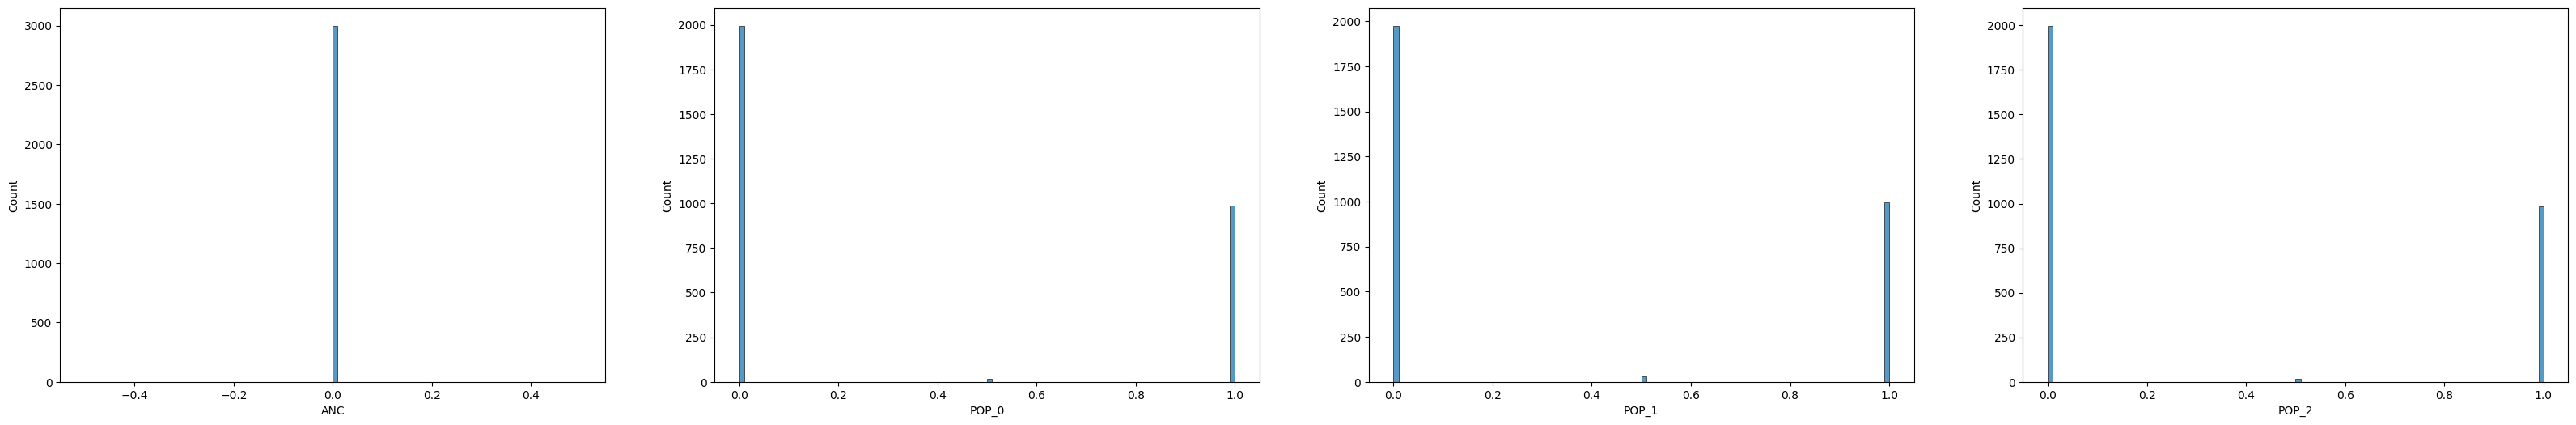

In [53]:
fig, ax = plt.subplots(ncols=len(ancestry_df.columns), figsize=(10*len(ancestry_df.columns), 6))

for i, pop in enumerate(ancestry_df.columns):
    sns.histplot(ancestry_df[pop], bins=100, ax=ax[i])

In [54]:
# frequency filter
freq_filter = diploid_G.mean(0) > 0.05
input_data = diploid_G[:, freq_filter]

# uniqueness filter
input_vars = input_data.std(0)
input_data = input_data[:, (input_vars != 0)]
input_vars = input_vars[(input_vars != 0)]

# normalize
input_data = (input_data - input_data.mean(0))/input_vars

emb = PCA(n_components=50).fit_transform(input_data)

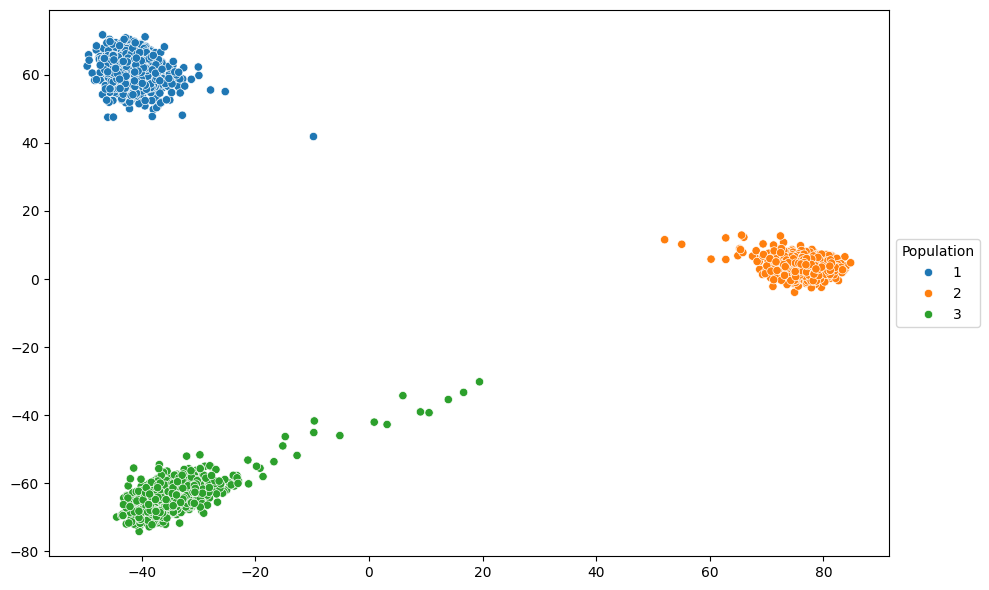

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=emb[:,0], 
                y=emb[:,1], 
                hue=pd.Categorical(metadata_df['population']),
                ax=ax)
# Move legend outside
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Population")

plt.tight_layout()

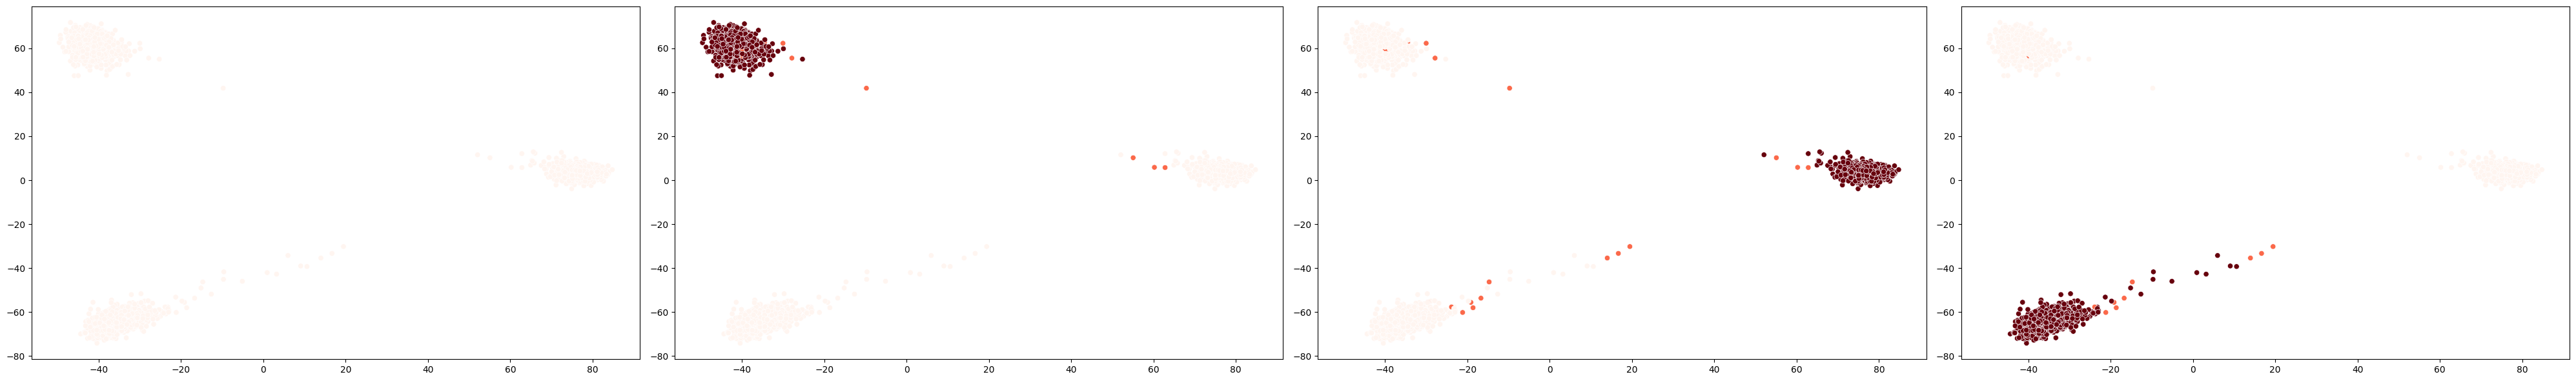

In [56]:
fig, ax = plt.subplots(ncols=len(ancestry_df.columns), figsize=(10*len(ancestry_df.columns), 6))

for i, pop in enumerate(ancestry_df.columns):
    sns.scatterplot(x=emb[:,0], 
                    y=emb[:,1], 
                    c=ancestry_df[pop],
                    cmap="Reds",
                    ax=ax[i])
    
plt.tight_layout()

In [60]:
phate_op = phate.PHATE(n_components=2, knn=200, t=5, decay=3)
phate_emb = phate_op.fit_transform(emb)

Calculating PHATE...
  Running PHATE on 3000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.05 seconds.
    Calculating affinities...
    Calculated affinities in 3.43 seconds.
  Calculated graph and diffusion operator in 6.44 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.99 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.20 seconds.
  Calculated landmark operator in 20.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.84 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.99 seconds.
Calculated PHATE in 31.81 seconds.


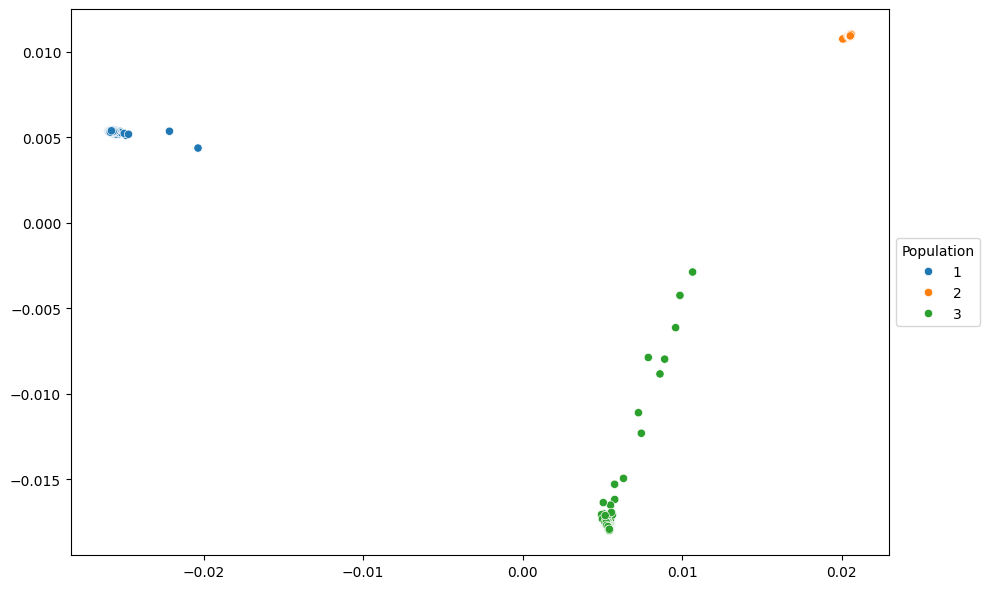

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=phate_emb[:,0], 
                y=phate_emb[:,1], 
                hue=pd.Categorical(metadata_df['population']),
                ax=ax)
# Move legend outside
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Population")

plt.tight_layout()

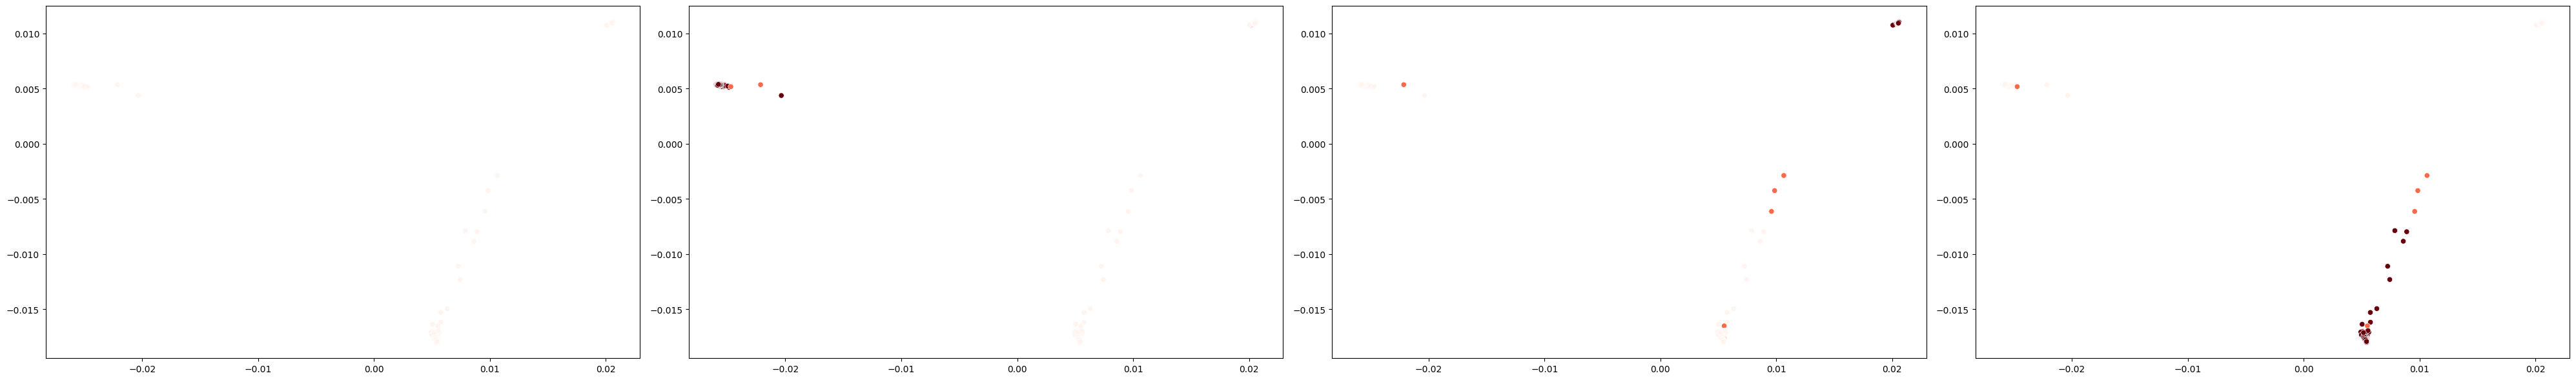

In [62]:
fig, ax = plt.subplots(ncols=len(ancestry_df.columns), figsize=(10*len(ancestry_df.columns), 6))

for i, pop in enumerate(ancestry_df.columns):
    sns.scatterplot(x=phate_emb[:,0], 
                    y=phate_emb[:,1], 
                    c=ancestry_df[pop],
                    cmap="Reds",
                    ax=ax[i])
    
plt.tight_layout()